<a href="https://colab.research.google.com/github/earthlovebpt/myprojects/blob/main/Fake_face_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=1g2ZzE9kztY9QeLIMvtDFm9Mk9D2YikUF)
# You can download dataset through this link [kaggle dataset](https://www.kaggle.com/xhlulu/140k-real-and-fake-faces).

# 0. Setup

In [ ]:
# Check GPU.
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8641133836669301279
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8729622654315903891
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -qq /content/drive/MyDrive/projects/fake-face-detection/archive.zip 

replace real_vs_fake/real-vs-fake/test/fake/00276TOPP4.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip3 install mtcnn

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from mtcnn.mtcnn import MTCNN
import cv2
from tqdm import tqdm_notebook as tq

#1. EDA

In [ ]:
path = '/content/real_vs_fake/real-vs-fake'

# Show the sample images.
def plot_img(path, class_):
    dir_ = os.path.join(path, 'train', class_)
    k = 0
    fig, ax = plt.subplots(3,3, figsize=(10,10))
    for j in range(3):
        for i in range(3):
            img = load_img(os.path.join(dir_, os.listdir(os.path.join(dir_))[k]))          
            ax[j,i].imshow(img)
            ax[j,i].set_title("")
            ax[j,i].axis('off')
            k +=1
    fig.tight_layout()
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

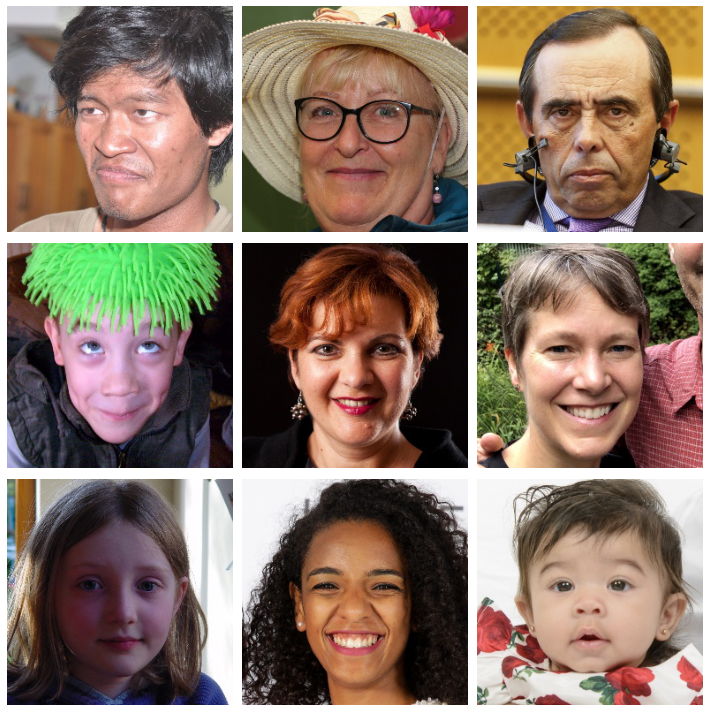

In [ ]:
plot_img(path, 'real')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

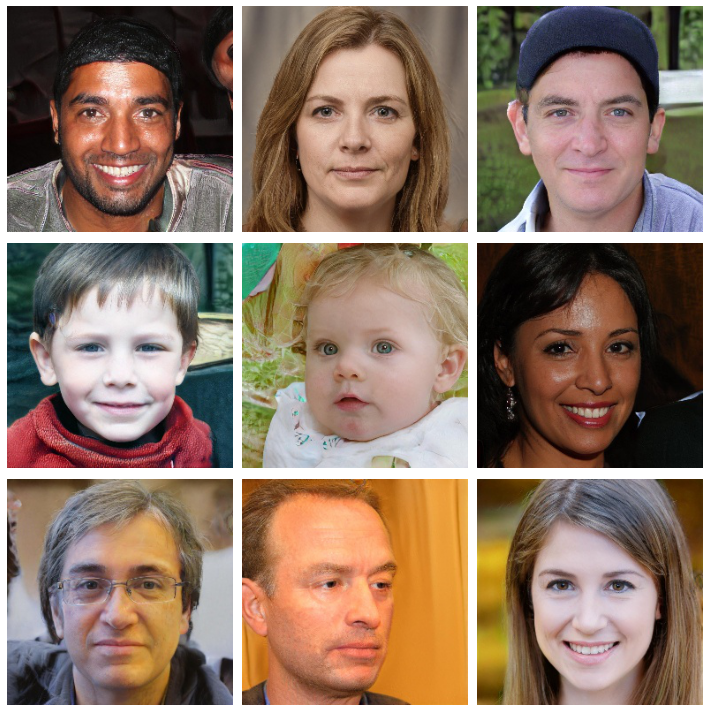

In [ ]:
plot_img(path, 'fake')

real    50000
fake    50000
Name: label_str, dtype: int64


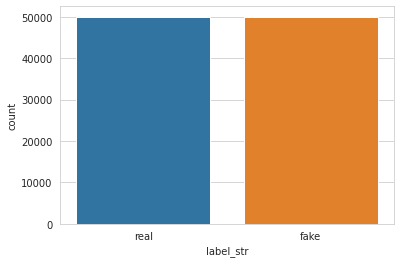

In [ ]:
# Show the number of Fake and Real face images.
train_df = pd.read_csv('/content/train.csv')
print(train_df['label_str'].value_counts())
sns.countplot(data=train_df, x='label_str')
plt.show()

#2. Face detection

In [ ]:
os.listdir('/content/real_vs_fake/real-vs-fake/train/real')[0]

'02805.jpg'

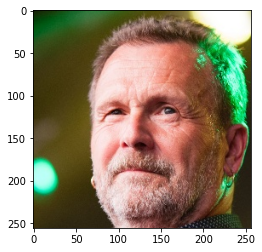

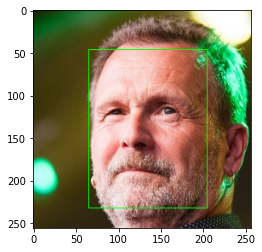

In [ ]:
# Read the sample image.
filename = '/content/real_vs_fake/real-vs-fake/train/real/44513.jpg'
img = cv2.imread(filename)

# Detect faces.
detector = MTCNN()
faces = detector.detect_faces(img)
x, y, w, h = faces[0]['box']

# Show the images.
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 1), cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Create folder.
!mkdir crop_img
!mkdir crop_img/train crop_img/train/real crop_img/train/fake
!mkdir crop_img/val crop_img/val/real crop_img/val/fake
!mkdir crop_img/test crop_img/test/real crop_img/test/fake

mkdir: cannot create directory ‘crop_img’: File exists
mkdir: cannot create directory ‘crop_img/train’: File exists
mkdir: cannot create directory ‘crop_img/train/real’: File exists
mkdir: cannot create directory ‘crop_img/train/fake’: File exists
mkdir: cannot create directory ‘crop_img/val’: File exists
mkdir: cannot create directory ‘crop_img/val/real’: File exists
mkdir: cannot create directory ‘crop_img/val/fake’: File exists
mkdir: cannot create directory ‘crop_img/test’: File exists
mkdir: cannot create directory ‘crop_img/test/real’: File exists
mkdir: cannot create directory ‘crop_img/test/fake’: File exists


In [ ]:
# Crop training images.
path = '/content/real_vs_fake/real-vs-fake/train/'
folders = os.listdir(path)

# Iterate over the folder and detect and crop faces and save them in respective folder.
for subs in folders:
    for files in tq(os.listdir(path+subs)[:10]):
        try:
            if subs=='fake':
                img = cv2.imread(path+subs+'/'+files)
                faces = detector.detect_faces(img)
                x, y, w, h = faces[0]['box']
                cv2.imwrite('/content/crop_img/train/fake/'+files, img[y:y+h, x:x+w])     
            elif subs=='real':
                img = cv2.imread(path+subs+'/'+files)
                faces = detector.detect_faces(img)
                x, y, w, h = faces[0]['box']
                cv2.imwrite('/content/crop_img/train/real/'+files, img[y:y+h, x:x+w])
        except:
            continue

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# Crop validation images.
path = '/content/real_vs_fake/real-vs-fake/valid/'
folders = os.listdir(path)

# Iterate over the folder and detect and crop faces and save them in respective folder.
for subs in folders:
    for files in tq(os.listdir(path+subs)[:10]):
        try:
            if subs=='fake':
                img = cv2.imread(path+subs+'/'+files)
                faces = detector.detect_faces(img)
                x, y, w, h = faces[0]['box']
                cv2.imwrite('/content/crop_img/val/fake/'+files, img[y:y+h, x:x+w])     
            elif subs=='real':
                img = cv2.imread(path+subs+'/'+files)
                faces = detector.detect_faces(img)
                x, y, w, h = faces[0]['box']
                cv2.imwrite('/content/crop_img/val/real/'+files, img[y:y+h, x:x+w])
        except:
            continue

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# Crop testing images.
path = '/content/real_vs_fake/real-vs-fake/test/'
folders = os.listdir(path)

# Iterate over the folder and detect and crop faces and save them in respective folder.
for subs in folders:
    for files in tq(os.listdir(path+subs)[:10]):
        try:
            if subs=='fake':
                img = cv2.imread(path+subs+'/'+files)
                faces = detector.detect_faces(img)
                x, y, w, h = faces[0]['box']
                cv2.imwrite('/content/crop_img/test/fake/'+files, img[y:y+h, x:x+w])     
            elif subs=='real':
                img = cv2.imread(path+subs+'/'+files)
                faces = detector.detect_faces(img)
                x, y, w, h = faces[0]['box']
                cv2.imwrite('/content/crop_img/test/real/'+files, img[y:y+h, x:x+w])
        except:
            continue

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

#3. Create the CNN model

In [ ]:
batch_size = 100
target_size = (224,224)
path = '/content/real_vs_fake/real-vs-fake'

generator = ImageDataGenerator()

# Prepare training dataset.
training_set = generator.flow_from_directory(path+'/train', target_size=target_size, batch_size=batch_size, class_mode='binary')

# Prepare validation dataset.
val_set = generator.flow_from_directory(path +'/valid', target_size=target_size, batch_size=batch_size, class_mode='binary')

# Prepare testing dataset.
test_set = generator.flow_from_directory(path+'/test', target_size=target_size, batch_size=batch_size, shuffle=False, class_mode='binary')

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [ ]:
inp = layers.Input(shape=(224, 224, 3))
base_model = tf.keras.applications.mobilenet.MobileNet(include_top=False, weights='imagenet', input_tensor=inp,input_shape=(224,224,3))
last_layer = base_model.get_layer('conv_pw_13_relu')
x = layers.GlobalAveragePooling2D()(last_layer.output)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs = inp, outputs = outputs)

# Compile the model.
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

# Print the model summary.
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [ ]:
# Save the best model.
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/projects/fake-face-detection/best_model.h5',
                             save_best_only=True,
                             verbose=1,
                             moniter='val_accuracy'
                            )

# Reduce lr when val_loss does not decrease.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.0001
                             )

# Earlystop when val_los does not decrease.
earlystop = EarlyStopping(monitor="val_loss", patience=5)

callbacks = [checkpoint, reduce_lr, earlystop]

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = val_set.n // val_set.batch_size

# Train the model
hist = model.fit(training_set,
                    validation_data=val_set,
                    callbacks=callbacks,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=5
                   )

Epoch 1/5
1000/1000 [==============================] - ETA: 0s - loss: 0.0771 - accuracy: 0.9686
Epoch 1: val_loss improved from inf to 0.02759, saving model to /content/drive/MyDrive/projects/fake-face-detection/best_model.h5
1000/1000 [==============================] - 467s 465ms/step - loss: 0.0771 - accuracy: 0.9686 - val_loss: 0.0276 - val_accuracy: 0.9891 - lr: 1.0000e-04
Epoch 2/5
1000/1000 [==============================] - ETA: 0s - loss: 0.0091 - accuracy: 0.9968
Epoch 2: val_loss improved from 0.02759 to 0.02691, saving model to /content/drive/MyDrive/projects/fake-face-detection/best_model.h5
1000/1000 [==============================] - 465s 465ms/step - loss: 0.0091 - accuracy: 0.9968 - val_loss: 0.0269 - val_accuracy: 0.9906 - lr: 1.0000e-04
Epoch 3/5
1000/1000 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.9981
Epoch 3: val_loss improved from 0.02691 to 0.01132, saving model to /content/drive/MyDrive/projects/fake-face-detection/best_model.h5
100

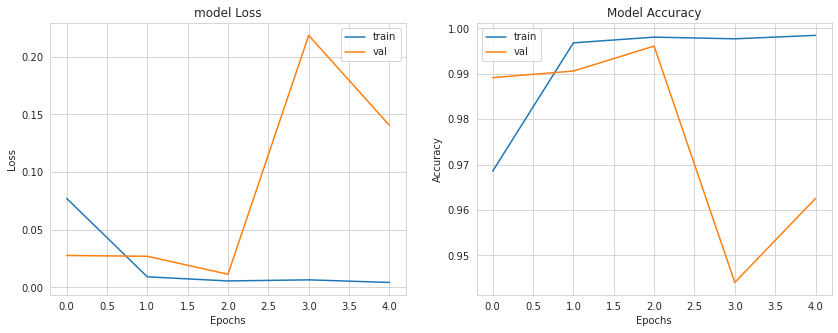

In [ ]:
def plot_history():
  plt.figure(figsize=(14,5))
  plt.subplot(1,2,2)
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'val'])

  plt.subplot(1,2,1)
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('model Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['train', 'val'])
  plt.show()

sns.set_style('whitegrid')
plot_history()

#4. Model evaluation

In [ ]:
# Load the best model
model = tf.keras.models.load_model('/content/drive/MyDrive/projects/fake-face-detection/best_model.h5')

In [ ]:
# Evaluate model on test set.
model.evaluate(test_set)

200/200 [==============================] - 39s 194ms/step - loss: 0.0116 - accuracy: 0.9959


[0.011581992730498314, 0.9958999752998352]

In [ ]:
# Predict the test set.
y_pred = model.predict(test_set)
y_test = test_set.classes

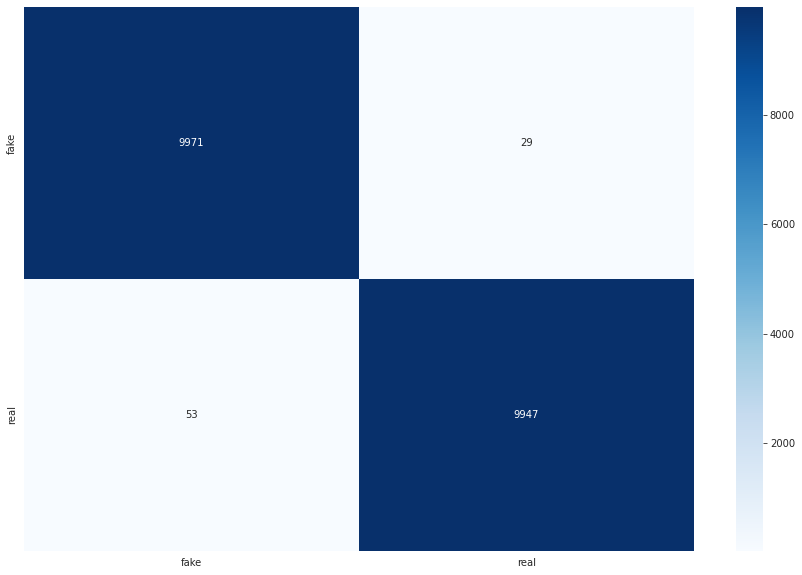

In [ ]:
# Show confusion matrix.
labels = ['fake', 'real']
plt.figure(figsize = (15,10))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred>0.5), annot = True,fmt="d",cmap = "Blues", xticklabels=labels, yticklabels=labels)
plt.show()

In [ ]:
# Show confusion report.
print(metrics.classification_report(y_test, y_pred>0.5))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     10000
           1       1.00      0.99      1.00     10000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



# 5. Re-Check by Grad-CAM algorithm

In [ ]:
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

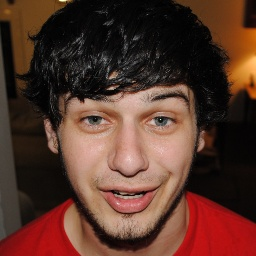

In [ ]:
path = '/content/real_vs_fake/real-vs-fake/test/fake'
path = '/content/real_vs_fake/real-vs-fake/test/real'
img_path = path + '/' + os.listdir(path)[1]

Image(img_path)

[[15.981309]]


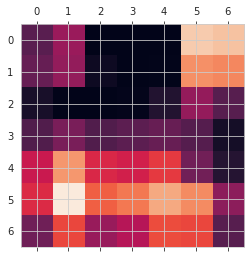

In [ ]:
last_conv_layer_name = "top_conv"
last_conv_layer_name = 'conv_pw_13_relu'

# Prepare image
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
img_array = preprocess_input(get_img_array(img_path, size=target_size))

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print(preds)


# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

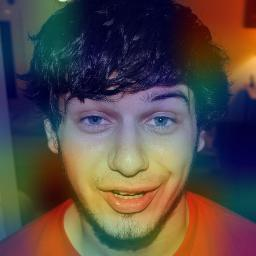

In [ ]:
save_and_display_gradcam(img_path, heatmap)

# 6. Only Face part version

In [ ]:
print('train real',len(os.listdir('/content/content/crop_img/train/real')))
print('train fake',len(os.listdir('/content/content/crop_img/train/fake')))

print('val real',len(os.listdir('/content/content/crop_img/val/real')))
print('val fake',len(os.listdir('/content/content/crop_img/val/fake')))

print('test real',len(os.listdir('/content/content/crop_img/test/real')))
print('test fake',len(os.listdir('/content/content/crop_img/test/fake')))

train real 9622
train fake 9905
val real 1927
val fake 1982
test real 1924
test fake 1984


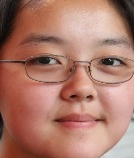

In [ ]:
path = '/content/content/crop_img/train/fake'
path = '/content/content/crop_img/train/real'
img_path = path + '/' + os.listdir(path)[0]

Image(img_path)

In [ ]:
batch_size = 100
target_size = (224,224)
path = '/content/content/crop_img'

generator = ImageDataGenerator()

# Prepare training dataset.
training_set = generator.flow_from_directory(path+'/train', target_size=target_size, batch_size=batch_size, class_mode='binary')

# Prepare validation dataset.
val_set = generator.flow_from_directory(path +'/val', target_size=target_size, batch_size=batch_size, class_mode='binary')

# Prepare testing dataset.
test_set = generator.flow_from_directory(path+'/test', target_size=target_size, batch_size=batch_size, shuffle=False, class_mode='binary')

Found 19527 images belonging to 2 classes.
Found 3909 images belonging to 2 classes.
Found 3908 images belonging to 2 classes.


In [ ]:
inp = layers.Input(shape=(224, 224, 3))
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inp,input_shape=(224,224,3))
last_layer = base_model.get_layer('top_conv')
x = layers.GlobalAveragePooling2D()(last_layer.output)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs = inp, outputs = outputs)

# Compile the model.
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

# Print the model summary.
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
# Save the best model.
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/projects/fake-face-detection/crop_model.h5',
                             save_best_only=True,
                             verbose=1,
                             moniter='val_accuracy'
                            )

# Reduce lr when val_loss does not decrease.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.0001
                             )

# Earlystop when val_los does not decrease.
earlystop = EarlyStopping(monitor="val_loss", patience=5)

callbacks = [checkpoint, reduce_lr, earlystop]

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = val_set.n // val_set.batch_size

# Train the model
hist = model.fit(training_set,
                    validation_data=val_set,
                    callbacks=callbacks,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=10
                   )

Epoch 1/10
195/195 [==============================] - ETA: 0s - loss: 0.3305 - accuracy: 0.8533
Epoch 1: val_loss improved from inf to 0.27856, saving model to /content/drive/MyDrive/projects/fake-face-detection/crop_model.h5
195/195 [==============================] - 139s 674ms/step - loss: 0.3305 - accuracy: 0.8533 - val_loss: 0.2786 - val_accuracy: 0.8823 - lr: 1.0000e-04
Epoch 2/10
195/195 [==============================] - ETA: 0s - loss: 0.0998 - accuracy: 0.9620
Epoch 2: val_loss improved from 0.27856 to 0.11425, saving model to /content/drive/MyDrive/projects/fake-face-detection/crop_model.h5
195/195 [==============================] - 131s 671ms/step - loss: 0.0998 - accuracy: 0.9620 - val_loss: 0.1143 - val_accuracy: 0.9546 - lr: 1.0000e-04
Epoch 3/10
195/195 [==============================] - ETA: 0s - loss: 0.0475 - accuracy: 0.9825
Epoch 3: val_loss improved from 0.11425 to 0.09621, saving model to /content/drive/MyDrive/projects/fake-face-detection/crop_model.h5
195/195 [=

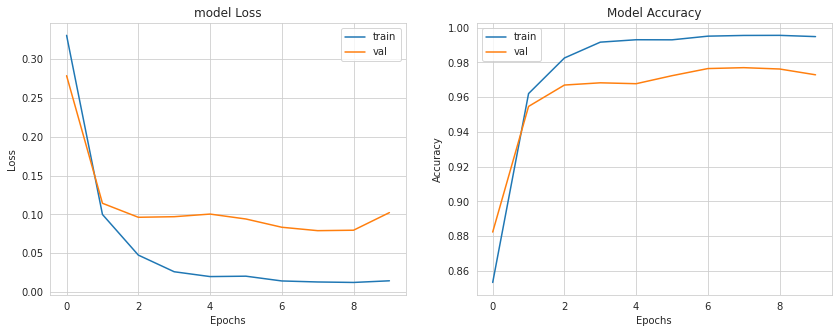

In [ ]:
def plot_history():
  plt.figure(figsize=(14,5))
  plt.subplot(1,2,2)
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'val'])

  plt.subplot(1,2,1)
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('model Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['train', 'val'])
  plt.show()

sns.set_style('whitegrid')
plot_history()

In [ ]:
# Load the best model
model = tf.keras.models.load_model('/content/drive/MyDrive/projects/fake-face-detection/crop_model.h5')

In [ ]:
# Evaluate model on test set.
model.evaluate(test_set)

40/40 [==============================] - 7s 132ms/step - loss: 0.0916 - accuracy: 0.9739


[0.09161616861820221, 0.9738997220993042]

In [ ]:
# Predict the test set.
y_pred = model.predict(test_set)
y_test = test_set.classes

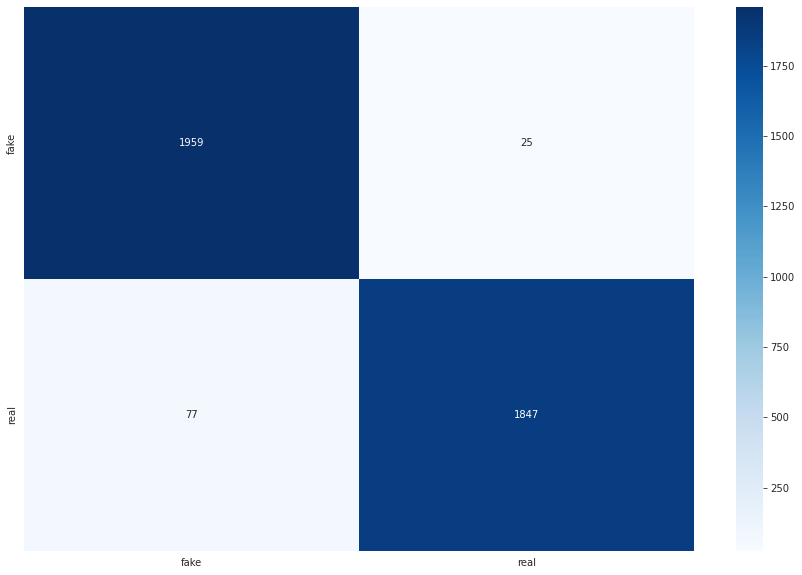

In [ ]:
# Show confusion matrix.
labels = ['fake', 'real']
plt.figure(figsize = (15,10))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred>0.5), annot = True,fmt="d",cmap = "Blues", xticklabels=labels, yticklabels=labels)
plt.show()

In [ ]:
# Show confusion report.
print(metrics.classification_report(y_test, y_pred>0.5))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1984
           1       0.99      0.96      0.97      1924

    accuracy                           0.97      3908
   macro avg       0.97      0.97      0.97      3908
weighted avg       0.97      0.97      0.97      3908



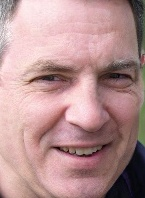

In [ ]:
path = '/content/content/crop_img/train/fake'
# path = '/content/content/crop_img/train/real'
img_path = path + '/' + os.listdir(path)[5]

Image(img_path)

[[-24.990143]]


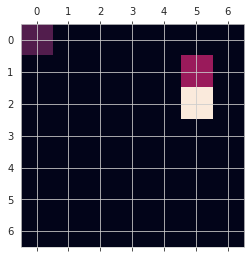

In [ ]:
last_conv_layer_name = "top_conv"

# Prepare image
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
img_array = preprocess_input(get_img_array(img_path, size=target_size))

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print(preds)


# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

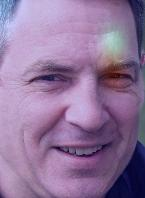

In [ ]:
save_and_display_gradcam(img_path, heatmap)